# Preliminaries + Installs

These instructions are for Python 3.10
### Install Ollama
* `cd /tmp`
* `curl -fsSL https://ollama.com/install.sh | sh`
* Test, Optional (2GB download): `ollama run llama3.2`, Type `/bye` when done
### Install Langchain
* `python3.10 -m pip install langchain langchain_community langchain_chroma langchain_ollama llama-index-legacy pypdf langchain-unstructured "unstructured[pdf]" --user`
### Install SQLite ( >= 3.35.0 required, This will install 3.46 )
* `sudo apt install libreadline-dev python3.10-dev`
* `wget https://sqlite.org/2024/sqlite-autoconf-3460100.tar.gz`
* `tar -xvf sqlite-autoconf-3460100.tar.gz && cd sqlite-autoconf-3460100`
* `./configure`
* `make`
* `sudo make install`
* `python3.10 -m pip uninstall pysqlite3`
* `python3.10 -m pip install pysqlite3-binary --user`

# Build/Expand Document Database + Embeddings

## State

In [1]:
from os import environ, path
import time, sys, json
now = time.time

environ["_RAG_STATE_PATH"] = "data/state.json"

RAGstate = {
    'libDocs' : list(),
    'pages'   : dict(),
}

def save_state():
    global RAGstate
    with open( environ["_RAG_STATE_PATH"], 'w' ) as f:
        json.dump( RAGstate, f, indent = 4 )

def load_state():
    global RAGstate
    try:
        with open( environ["_RAG_STATE_PATH"], 'r' ) as f:
            RAGstate = json.load(f)
    except FileNotFoundError as e:
        print( f"Could not load {environ['_RAG_STATE_PATH']}!\n{e}" )

load_state()

## Helper Functions

In [2]:
from uuid import uuid4

def safe_str( data ):
    """Filters out invalid UTF-8 characters from a string."""
    return str( data ).encode( 'utf-8', 'ignore' ).decode( 'utf-8' )

def gen_ID():
    """ Generate a unique ID """
    return safe_str( uuid4() )

def pull_ollama_model( modelStr ):
    """ Pull a named model from Ollama and store it wherever """
    print( f"About to save '{modelStr}'.\nThis will spew a lot of text on the first run..." )
    os.system( f"ollama pull {modelStr}" )



## Copy PDFs

In [3]:
import os
from os import path, makedirs
# from aa_scrape_PDF import copy_pdfs

environ["_RAG_PDF_SOURCE"] = "/media/james/FILEPILE/$_Robust_Planning/Literature/References/storage"
environ["_RAG_PDF_DESTIN"] = "data/input/pdf"
environ["_RAG_PDF_ERROR"]  = "data/input/BAD_PDF"
environ["_RAG_PAGE_DESTN"] = "data/input/pages"
environ["_RAG_VERBOSE"]    =    ""
environ["_RAG_DOC_ADD"]    =   "200" #"25" #"200"
environ["_RAG_DOC_LIMIT"]  = "10000"
environ["_RAG_DOC_DBASE"]  = "lit_pdf"

if not path.exists( environ["_RAG_PDF_ERROR"] ):
    makedirs( environ["_RAG_PDF_ERROR"] )


## Determine if more docs will be loaded this session

In [4]:
%%capture
# Loading the vector store sometimes spews warnings

__import__('pysqlite3')
sys.modules['sqlite3'] = sys.modules.pop( 'pysqlite3' )
import chromadb
from langchain_chroma import Chroma


persistent_client = chromadb.PersistentClient();
collection        = persistent_client.get_or_create_collection( environ["_RAG_DOC_DBASE"] );

pdfs_drct   = environ["_RAG_PDF_DESTIN"]
eror_drct   = environ["_RAG_PDF_ERROR" ]
fNames      = [item for item in os.listdir( pdfs_drct ) if (str( item ).split('.')[-1].lower() == 'pdf')]

environ["_RAG_PDF_COUNT"   ] = str( len( fNames ) )
environ["_RAG_DOCDB_COUNT" ] = str( collection.count() )
environ["_RAG_DOCDB_REMAIN"] = str( min( int(environ["_RAG_DOC_LIMIT"])-len(RAGstate['libDocs']), int(environ["_RAG_DOC_ADD"]) ) )


In [5]:
from utils import copy_pdfs

print( f"{environ['_RAG_PDF_COUNT' ]} input PDFs exist!" )
print( f"{environ['_RAG_DOCDB_COUNT' ]} vector records exist!" )
print( f"{environ['_RAG_DOCDB_REMAIN']} files will be copied!" )

copy_pdfs( environ["_RAG_PDF_SOURCE"], environ["_RAG_PDF_DESTIN"], 
           int(environ['_RAG_DOCDB_REMAIN']), verbose = environ["_RAG_VERBOSE"] )

2723 input PDFs exist!
61203 vector records exist!
200 files will be copied!
.......................................................


## Load PDFs by page chunks

### https://python.langchain.com/docs/how_to/document_loader_pdf/

* `python3.10 -m pip install pypdf langchain-unstructured "unstructured[pdf]" --user`
* `apt install tesseract-ocr`

In [6]:

def collect_unique_metadata_by_key( key ):
    """ Return a list of unqiue metadata values from the vector store by `key` """
    global collection
    unique = set()
    for result in collection.get()['metadatas']:
       if key in result:
           unique.add( result[key] )
    return list( unique )


def find_unread_PDFs_at_input():
    """ Return a list of PDF paths that do NOT have pages in the vector store """
    global RAGstate
    inputPDFs = collect_unique_metadata_by_key( 'source' )
    rtnPaths  = list()
    for pdf in inputPDFs:
        if pdf not in RAGstate['libDocs']:
            rtnPaths.append( pdf )
    return rtnPaths
            

In [7]:
import os, shutil
from collections import deque
from langchain_community.document_loaders import PyPDFLoader

pages = deque() # Fast append


# needToParse = find_unread_PDFs_at_input()
# fNames.extend( needToParse )

print( f"There are {len(fNames)} candidate files!" )

if len( fNames ) > 0:
    bgn    = now()
    lastLn = 0
    Nexist = 0
    
    for i, fNam in enumerate( fNames ):
        file_path = str( path.join( pdfs_drct, fNam ) ) # fNam # str( path.join( pdfs_drct, fNam ) )
        if file_path not in RAGstate['libDocs']:
            try:
                loader    = PyPDFLoader( file_path )
                async for page in loader.alazy_load():
                    pages.append( page )
                print( f"{i+1}:{len(pages)-lastLn}:{len(pages)}", end = ', ', flush = True )
                lastLn = len(pages)
            except Exception as e:
                print( f"ERROR:{e}", end = ', ', flush = True )
                try:
                    shutil.move( file_path, path.join( eror_drct, fNam ) )
                except Exception as e:
                    print( f"FAILED to move {file_path} --to-> {path.join( eror_drct, fNam )}" )
            except asyncio.CancelledError as e:
                print( f"Load operation cancelled by user" )
                raise e
        else:
            Nexist += 1
                    
    print()
    pages = list( pages )
    print( f"Read {len(pages)} pages in {(now()-bgn)/60.0:.2f} minutes! (Skipped {Nexist} existing PDFs.)" )

save_state()

There are 2723 candidate files!
2:10:10, 14:12:22, 29:11:33, 122:21:54, 143:22:76, 157:3:79, 190:8:87, 192:657:744, 210:12:756, 218:6:762, 221:395:1157, 223:14:1171, 247:9:1180, 248:24:1204, 250:6:1210, 261:21:1231, 269:27:1258, 283:20:1278, 296:14:1292, 321:12:1304, 322:6:1310, 323:9:1319, 338:23:1342, 339:16:1358, 345:7:1365, 372:16:1381, 389:13:1394, 395:10:1404, 405:8:1412, 421:29:1441, 439:14:1455, 448:14:1469, 

Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 23 0 (offset 0)
Ignoring wrong pointing object 25 0 (offset 0)
Ignoring wrong pointing object 50 0 (offset 0)
Ignoring wrong pointing object 107 0 (offset 0)
Ignoring wrong pointing object 109 0 (offset 0)
Ignoring wrong pointing object 112 0 (offset 0)
Ignoring wrong pointing object 138 0 (offset 0)
Ignoring wrong pointing object 141 0 (offset 0)
Ignoring wrong pointing object 143 0 (offset 0)
Ignoring wrong pointing object 145 0 (offset 0)
Ignoring wrong pointing object 147 0 (offset 0)
Ignoring wrong pointing object 153 0 (offset 0)
Ignoring wrong pointing object 156 0 (offset 0)
Ignoring wrong pointing object 159 0 (offset 0)
Ignoring wrong pointing object 190 0 (offset 0)
Ignoring wrong pointing object 193 0 (offset 0)
Ignoring wrong pointing object 195 0 (offset 0)
Ignoring wrong pointing object 211 0 (offset 0)
Ignoring wrong pointing object 213 0 (offset 

490:47:1516, 491:4:1520, 514:22:1542, 517:16:1558, 518:13:1571, 526:10:1581, 548:9:1590, 573:8:1598, 577:9:1607, 595:16:1623, 599:15:1638, 606:19:1657, 614:17:1674, 618:7:1681, 625:18:1699, 667:9:1708, 688:12:1720, 716:12:1732, 799:1:1733, 814:17:1750, 822:5:1755, 835:9:1764, 858:12:1776, 859:2:1778, 870:35:1813, 878:61:1874, 879:413:2287, 893:16:2303, 909:857:3160, 929:14:3174, 932:10:3184, 934:24:3208, 936:17:3225, 941:9:3234, 949:12:3246, 959:19:3265, 964:11:3276, 967:7:3283, 980:13:3296, 981:30:3326, 986:17:3343, 992:9:3352, 1004:12:3364, 1013:18:3382, 1029:39:3421, 1032:20:3441, 1037:14:3455, 1051:4:3459, 1082:7:3466, 1103:22:3488, 1104:14:3502, 1134:14:3516, 1138:10:3526, 1148:7:3533, 1166:16:3549, 1169:20:3569, 1197:7:3576, 1223:7:3583, 1234:15:3598, 1240:11:3609, 1257:8:3617, 1266:8:3625, 1280:8:3633, 

incorrect startxref pointer(1)


1287:4:3637, 1304:6:3643, 1332:22:3665, 1352:6:3671, 1356:6:3677, 1362:31:3708, 1384:112:3820, 1415:11:3831, 1425:14:3845, 1437:18:3863, 1438:8:3871, 1450:151:4022, 1465:32:4054, 1471:51:4105, 1485:14:4119, 1501:18:4137, 1503:16:4153, 1517:12:4165, 1518:29:4194, 1524:7:4201, 1529:11:4212, 1533:6:4218, 1550:7:4225, 1570:7:4232, 1587:6:4238, 1591:12:4250, 1626:16:4266, 1627:12:4278, 

Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet


1635:19:4297, 1636:8:4305, 1692:32:4337, 1695:13:4350, 1704:25:4375, 1724:10:4385, 

could not convert string to float: '0.000000000000-5684342' : FloatObject (b'0.000000000000-5684342') invalid; use 0.0 instead


1740:18:4403, 1767:6:4409, 1772:7:4416, 1780:38:4454, 1801:6:4460, 1823:13:4473, 1826:38:4511, 1848:11:4522, 1850:10:4532, 1864:19:4551, 1890:16:4567, 1896:6:4573, 1901:13:4586, 1921:26:4612, 1924:8:4620, 1938:10:4630, 1971:17:4647, 1979:8:4655, 1986:28:4683, 2012:8:4691, 2025:19:4710, 2030:15:4725, 2062:5:4730, 2065:13:4743, 2078:16:4759, 2080:25:4784, 2091:80:4864, 2107:8:4872, 2163:240:5112, 2182:20:5132, 2183:18:5150, 2197:15:5165, 2202:12:5177, 2239:9:5186, 2251:4:5190, 2283:26:5216, 2287:6:5222, 2291:26:5248, 2292:9:5257, 2293:6:5263, 2295:9:5272, 2305:23:5295, 2354:11:5306, 2365:6:5312, 2374:15:5327, 2376:50:5377, 

Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet


2377:205:5582, 2380:21:5603, 2400:9:5612, 2402:28:5640, 2413:30:5670, 2414:17:5687, 2430:20:5707, 2437:16:5723, 2439:21:5744, 2486:15:5759, 2491:25:5784, 2522:12:5796, 2527:8:5804, 2546:28:5832, 2553:11:5843, 2596:116:5959, 2605:1:5960, 2619:28:5988, 2621:50:6038, 2630:241:6279, 2634:20:6299, 2676:23:6322, 2677:12:6334, 2703:11:6345, 2720:8:6353, 
Read 6353 pages in 4.58 minutes! (Skipped 2523 existing PDFs.)


In [8]:
# print(f"{pages[0].metadata}\n")
# print(pages[0].page_content)

## Load the text embedding model

In [9]:
import sys, os, time
now = time.time

from langchain_ollama import OllamaEmbeddings

pull_ollama_model( "all-minilm" )

local_embeddings = OllamaEmbeddings( model = "all-minilm" )

About to save 'all-minilm'.
This will spew a lot of text on the first run...


pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest 
pulling 797b70c4edf8... 100% ▕████████████████▏  45 MB                         
pulling c71d239df917... 100% ▕████████████████▏  11 KB                         
pulling 85011998c600... 100% ▕████████████████▏   16 B                         
pulling 548455b72658... 100% ▕████████████████▏  407 B                         
verifying sha256 digest 
writing manifest 
success 


## Populate document vector database (of pages)

In [10]:
import base64
import io

import fitz, pymupdf
from PIL import Image


def pdf_page_to_base64( pdf_path: str, page_number: int ):
    zoom_x       = 1.5  # horizontal zoom
    zoom_y       = 1.5  # vertical zoom
    mat          = pymupdf.Matrix( zoom_x, zoom_y )
    pdf_document = fitz.open( pdf_path )
    page         = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix          = page.get_pixmap( matrix = mat )
    img          = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    buffer       = io.BytesIO()
    
    img.save( buffer, format="PNG" )

    return base64.b64encode( buffer.getvalue() ).decode("utf-8")

In [11]:
import pickle

if not path.exists( environ["_RAG_PAGE_DESTN"] ):
    makedirs( environ["_RAG_PAGE_DESTN"] )


def get_page_meta_key( source, page ):
    """ Generate a (probably not) unique page key with useful data that can also be used for sorting """
    return str( source ).split('/')[-1].replace(' ','') + '_' + str( page )


if int(environ["_RAG_DOCDB_REMAIN"]) > 0:
    bgn = now()
    docIDs  = [str( gen_ID() ) for _ in range( len(pages) )]
    dcmnts  = [str( pg.page_content ) for pg in pages]
    metaDt  = list()
    d       = 50
    readSet = set([])

    for i, pg in enumerate( pages ):

        id_i  = docIDs[i]
        
        # Save Text Metadata #
        mDct = pg.metadata
        mDct['metakey'] = get_page_meta_key( pg.metadata['source'], pg.metadata['page'] )
        mDct['docID'  ] = id_i
        metaDt.append( mDct )

        src = pg.metadata['source']

        #  vv- Quick Search -vv     vvvvv--- Long Search ---vvvvvvvv
        if (src not in readSet) and (src not in RAGstate['libDocs']):
            readSet.add( src )
            RAGstate['libDocs'].append( src )

        # Save PDF Page image #
        try:
            pkl_i = path.join( environ["_RAG_PAGE_DESTN"], f"{id_i}.pkl" )
            pgPic = pdf_page_to_base64( pg.metadata['source'], pg.metadata['page'] )
            
            with open( pkl_i, 'wb' ) as f:
                RAGstate['pages'][ id_i ] = str( pkl_i )
                pickle.dump( pgPic, f )
        except Exception as e:
            print( f"Could NOT save image ID {id_i}!, {e}" )

        if (i % d == 0):
            print( '.', end='', flush = True )
    print()
    
    collection.add(
        ids       = docIDs, 
        metadatas = metaDt,
        documents = dcmnts
    )
    print( f"Added {len(dcmnts)} documents in {(now()-bgn)/60.0:.2f} minutes!" )

save_state()



................................................................................................................................


Exception occurred invoking consumer for subscription 0673e0ae370e4301952fc7117eee8c82to topic persistent://default/default/a84553ac-5e8e-4481-8051-a5e59bf2af75 'utf-8' codec can't encode character '\udc52' in position 215: surrogates not allowed


Added 6353 documents in 11.89 minutes!


# Create vector store

In [12]:
bgn = now()
vector_store_from_client = Chroma(
    client             = persistent_client,
    collection_name    = environ["_RAG_DOC_DBASE"],
    embedding_function = local_embeddings,
)
print( f"Built vector store in {(now()-bgn):.4f} seconds!" )

Built vector store in 0.0049 seconds!


# Load VLM

In [13]:
from langchain_ollama import ChatOllama

pull_ollama_model( "llava" )

llm = ChatOllama(
    model="llava",
)

About to save 'llava'.
This will spew a lot of text on the first run...


pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠼ pulling manifest 
pulling 170370233dd5... 100% ▕████████████████▏ 4.1 GB                         
pulling 72d6f08a42f6... 100% ▕████████████████▏ 624 MB                         
pulling 43070e2d4e53... 100% ▕████████████████▏  11 KB                         
pulling c43332387573... 100% ▕████████████████▏   67 B                         
pulling ed11eda7790d... 100% ▕████████████████▏   30 B                         
pulling 7c658f9561e5... 100% ▕████████████████▏  564 B                         
verifying sha256 digest 
writing manifest 
success 


# Setup LangChain

In [14]:
os.environ["LANGCHAIN_TRACING_V1"] = "false"
os.environ["LANGCHAIN_TRACING_V2"] = "false"

# from langchain import hub
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser

# Retrieve and generate using the relevant snippets of the blog.
retriever = vector_store_from_client.as_retriever()

# Instantiation using from_template (recommended)
prompt1 = PromptTemplate( 
    template = """You are an expert assistant capable of interpreting textual information to provide accurate 
                  and detailed responses. You are provided with the following data:
                  Context: {docData}
                  Text query: {userQuery}
                  Use your understanding of the provided context to generate a response to based on 
                  relevant, up-to-date information. Ensure your answer is factually accurate, detailed, and leverages academic 
                  sources where possible. If additional context is required for clarification, request it from the user.""",
    input_variables = ["docData","userQuery"],
)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain1 = (
    { "docData": retriever | format_docs, 
      "userQuery": RunnablePassthrough()}
    | prompt1
    | llm
    | StrOutputParser()
)

In [15]:
def ask_with_sources( q ):
    retrieved_docs = retriever.invoke( q )
    generated_ansr = rag_chain1.invoke( q )
    return {
        'response' : generated_ansr,
        'sources'  : retrieved_docs,
    }

In [16]:
def fetch_local_pages( sourceList ):
    global RAGstate
    rtnObjs = list()
    for source in sourceList:
        if source.metadata['docID'] in RAGstate['pages']:
            pklPath = RAGstate['pages'][ source.metadata['docID'] ]
            with open( pklPath, 'rb' ) as f:
                obj_i = pickle.load( f )
                rtnObjs.append( obj_i )
        else:
            print( f"No page with ID {source.metadata['docID']}" )
    return rtnObjs

In [17]:
from pprint import pprint
from IPython.display import Image as IPImage
from IPython.display import display
from langchain_core.messages import HumanMessage

def deep_doc_ask( q ):
    bgn = now()
    res = ask_with_sources( q ) 
    pprint( res['response'] )
    print( f"Initial LLM summary took {now()-bgn:.2f} seconds to process!" )
    
    pag = fetch_local_pages( res['sources'] )

    for p in pag:
        display( IPImage( data = base64.b64decode( p ) ) )
        message = HumanMessage(
            content=[
                {"type": "text", "text": q},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{p}"},
                },
            ],
        )
        bgn = now()
        response = llm.invoke( [message] )
        print( f"LLM query took {now()-bgn:.2f} seconds to process!" )
        pprint( response.content )

(' Nuclear fusion occurs when two or more atomic nuclei combine to form a '
 'single, heavier nucleus, releasing large amounts of energy in the process. '
 'This phenomenon is the same mechanism that powers the sun and other stars, '
 'but achieving controlled nuclear fusion on Earth has proven to be a '
 'challenging task.\n'
 '\n'
 'In order for nuclear fusion to occur, certain conditions must be met. '
 'Firstly, the plasma must be at a high enough temperature and density. This '
 'allows the atomic nuclei to overcome their electrostatic repulsion and come '
 'into close enough contact to form heavier nuclei. The exact temperature '
 'required for fusion varies depending on the specific elements involved, but '
 'it is generally in the range of 100 million to 1 billion degrees Celsius.\n'
 '\n'
 'Secondly, the plasma must be confined in a stable manner. This prevents the '
 'hot plasma from coming into contact with the walls of the containment '
 'vessel, which would result in the l

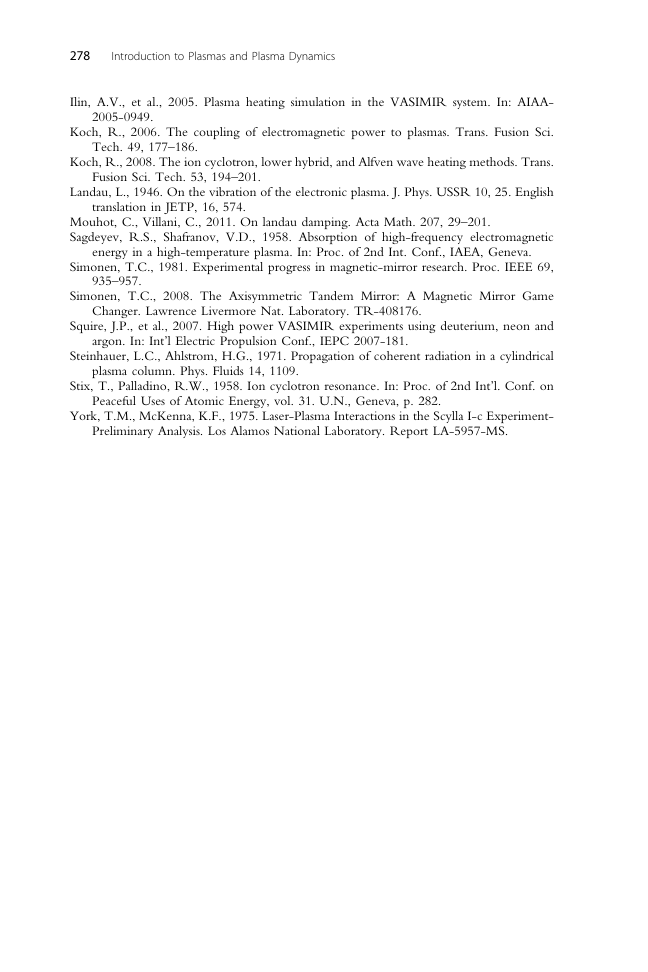

LLM query took 22.29 seconds to process!
(' This image appears to show a document or article with text written in '
 'English. The text is discussing the conditions necessary for nuclear fusion '
 'in a confined plasma, which are as follows:\n'
 '\n'
 '1. The plasma must be at high temperature (typically in excess of 100 '
 'million degrees Celsius).\n'
 '2. The density of the plasma must be very high to overcome the electrostatic '
 'repulsion between the positively charged nuclei and allow a fusion reaction '
 'to occur. This can be achieved by using magnetic confinement methods such as '
 'tokamaks or stellarators, which trap the plasma in a controlled '
 'environment.\n'
 '3. The confinement system must prevent the hot plasma from touching any '
 'solid surfaces, as this would quench the reaction and cause the plasma to '
 'rapidly cool down.\n'
 '4. The plasma must be well-controlled so that no impurities or contaminants '
 'interfere with the fusion process. This requires a high 

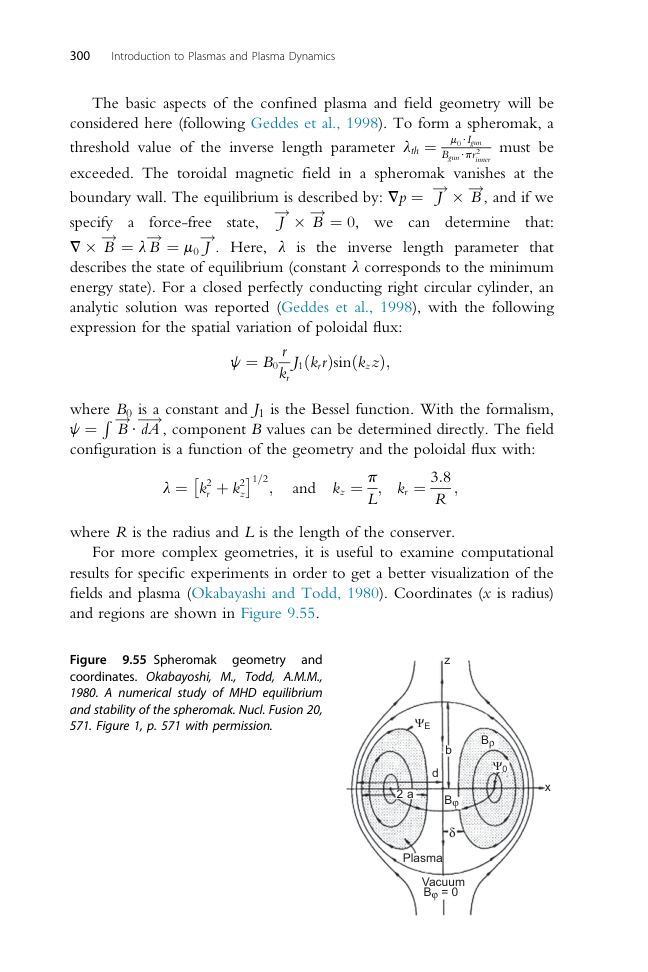

LLM query took 19.30 seconds to process!
(' The image displays a scientific paper with a page of text and diagrams. The '
 'title of the paper is "Accessory to the fundamental principles of '
 'magnetohydrodynamics." Below the title, there\'s a subtitle that reads "A '
 'discussion of the magnetic field effects on the motion of electrically '
 'charged particles."\n'
 '\n'
 'In the body of the paper, there are equations and diagrams related to '
 'physics. The text is discussing the conditions necessary for nuclear fusion '
 'in a confined plasma. It explains how the energy required for nuclear fusion '
 'can be provided by the kinetic energy of the plasma itself. The diagram on '
 'the left appears to be schematic, showing the relationship between magnetic '
 'field lines, electrically charged particles (ions), and their motion within '
 'the plasma.\n'
 '\n'
 'The diagram illustrates how the magnetic field interacts with the ions, '
 'which are moving in circular orbits. This interac

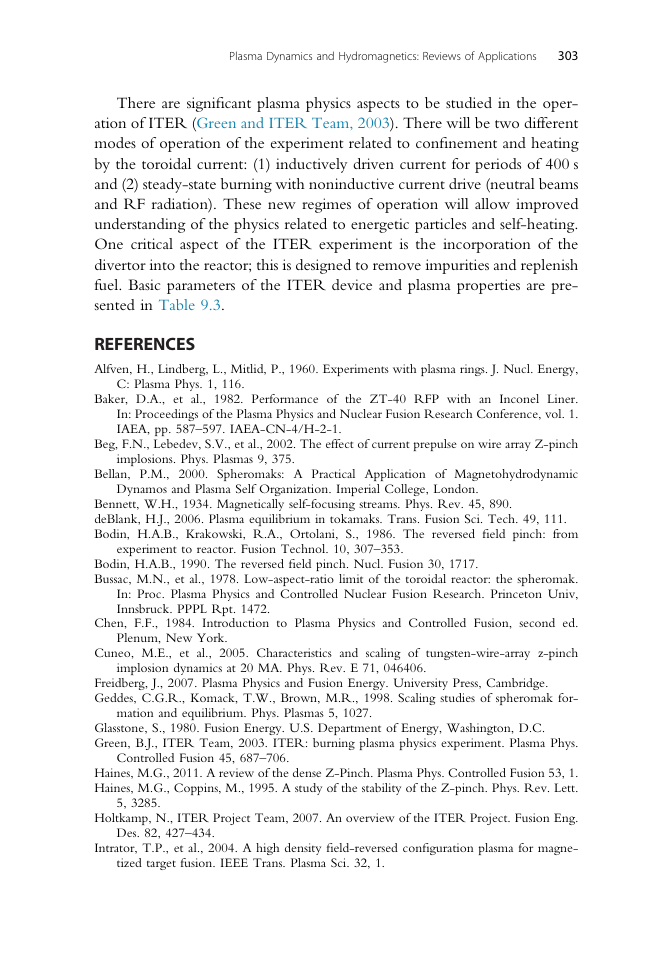

LLM query took 19.48 seconds to process!
(' The image shows a page from a scientific or academic paper. The content of '
 'the page includes a title, references, and a body text section. The title is '
 'not fully visible in the image, but it appears to be related to plasma '
 'physics.\n'
 '\n'
 'The body text discusses conditions necessary for nuclear fusion in confined '
 'plasmas. It mentions that these conditions include magnetic confinement, an '
 'ionized gas (plasma), and heating of this plasma to high temperatures (10^6 '
 'K) in order to achieve the required reaction rates and temperatures '
 'necessary for sustained nuclear fusion. The text also describes that various '
 'experimental and theoretical approaches have been employed in the search for '
 'practical fusion reactors, with different devices used for containment, such '
 'as tokamaks, stellarators, and laser-based systems like laser ablation in '
 'hydrogen isotopes.\n'
 '\n'
 'The references section lists a series 

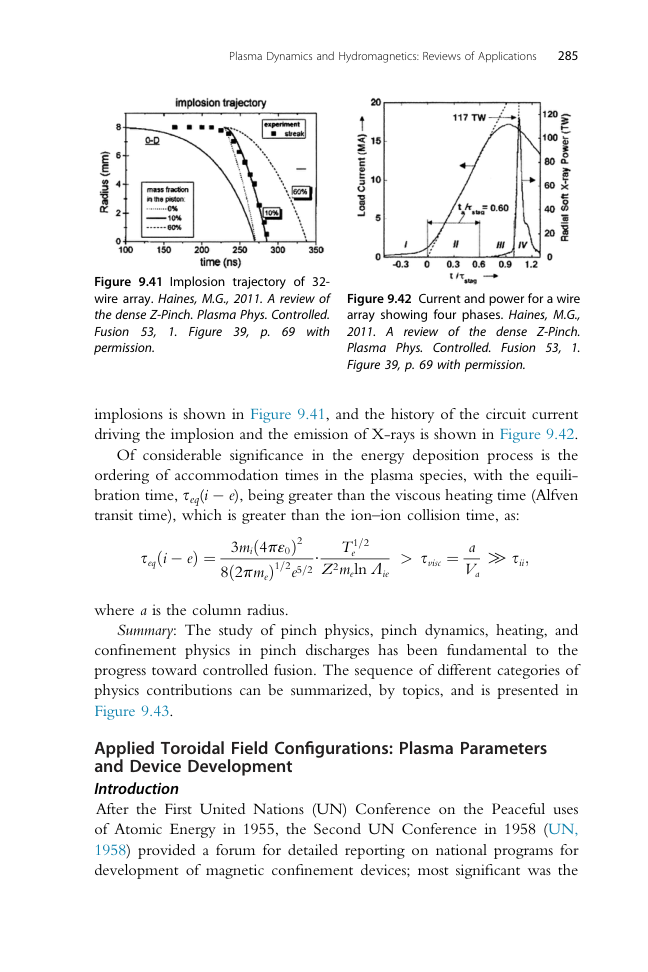

LLM query took 11.78 seconds to process!
(" The image you've shared is of a scientific paper, and it appears to be "
 'discussing the conditions necessary for nuclear fusion in a confined plasma. '
 'While I can see the title "TORADAL FIELD CONFIGURATIONS FOR '
 'PLASMA-CONFINEMENT," which suggests that the paper is about the '
 "configuration of magnetic fields for containing and controlling plasma, I'm "
 'unable to provide specific details about the content of the paper as it '
 'requires the ability to read text in an image. If you have any questions '
 'about the topic or need information on how to understand the conditions for '
 'nuclear fusion, feel free to ask! ')


In [18]:
deep_doc_ask( "Describe the conditions necessary for nuclear fusion in a confined plasma." )